#**Домашнее задание №5. Часть 1. Autoencoders_PyTorch**<br>
**Выполнила: FIO.**


Сравним работу 3-х автокодировщиков:<br>
*   PCA
*   DeepAutoencoder
*   CNNAutoencoder





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/14_week

/content/gdrive/My Drive/14_week


In [2]:
 # Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

**Примечание: размер исходного датасета урезан до 2000 объектов из-за долгого обучения сверточного автокодировщика.**

In [5]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(data_home='./', min_faces_per_person=0, resize=0.5, color=True,
                              slice_=(slice(94, 190, None), slice(78, 174, None)), download_if_missing=True)

In [4]:
from sklearn.model_selection import train_test_split

X = lfw_people.images[:2000]
X = np.moveaxis(X, 3, 1)
IMG_SHAPE = X.shape[1:]

X = X.astype('float32') / 255.0
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

NameError: name 'lfw_people' is not defined

In [3]:
plt.imshow(np.moveaxis(X_train[0], 0, 2))
X_train[0].shape

NameError: name 'X_train' is not defined

In [7]:
np.moveaxis(X_train[0], 0, 2).shape

(48, 48, 3)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

BATCH_SIZE = 256

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

EPOCHS = 40
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = X_train.shape[1:]
input_shape
print(DEVICE)

cpu


In [ ]:
input_shape

In [10]:
from IPython import display  # выводить график обучения в онлайн режиме
from tqdm.auto import tqdm
import os

In [11]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

def train(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())

        model.eval()
        with torch.no_grad():
            for X in val_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch)

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 25 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

In [12]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#plot(train_loss, val_loss)

In [13]:
# Функция для отрисовки оригинальных цифр, их представления и восстановленного рисунка
def visualize(img, model, div_coef=2):
    with torch.no_grad():
        x = torch.flatten(img)
        x = x[None, :]
        latent_code = model.encoder(x.to(DEVICE))[0].cpu()

        reco, _ = model(img[None, :, :, :].to(DEVICE))
        reco = reco[0].cpu()
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(latent_code.reshape([latent_code.shape[-1]//div_coef,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1).permute(1, 2, 0))
    plt.show()

In [14]:
class PcaAutoencoder(nn.Module):

    def __init__(self, img_shape, code_size=36):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        self.encoder = nn.Linear(np.prod(img_shape), code_size)
        self.decoder = nn.Linear(code_size, np.prod(img_shape))

    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
EPOCHS = 40

# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = PcaAutoencoder(input_shape)
autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

cpu


In [16]:
model, train_loss, val_loss = train(autoencoder, 
                                    train_loader, test_loader, 
                                    device=DEVICE, epochs=200, 
                                    path='pca_autoencoder')
torch.save(model.state_dict(), 'pca_autoencoder/pca_auto_model_final.pt')

  0%|          | 0/200 [00:00<?, ?it/s]

After 0 epochs, training loss: 1.312181;   val loss: 0.369949
After 25 epochs, training loss: 0.145613;   val loss: 0.088345
After 50 epochs, training loss: 0.085756;   val loss: 0.056188
After 75 epochs, training loss: 0.065219;   val loss: 0.045139
After 100 epochs, training loss: 0.054808;   val loss: 0.039525
After 125 epochs, training loss: 0.048496;   val loss: 0.036109
After 150 epochs, training loss: 0.044273;   val loss: 0.033853
After 175 epochs, training loss: 0.041253;   val loss: 0.032200


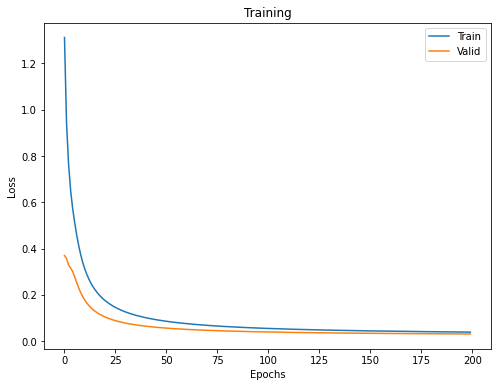

In [17]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot(train_loss, val_loss)

Final MSE: 0.030980721


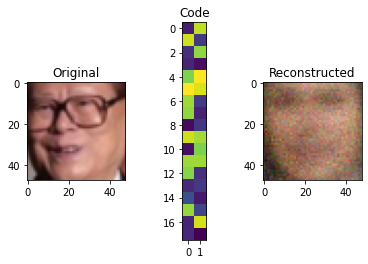

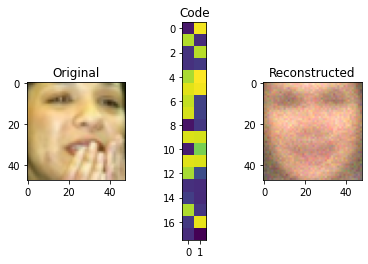

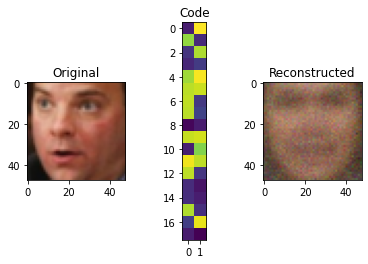

In [18]:
score = val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img, model)

In [19]:
class DeepAutoencoder(nn.Module):

    def __init__(self, img_shape, code_size=150):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()
        
        def initialization(layer):
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.)
        
        self.encoder = nn.Sequential(nn.Linear(np.prod(img_shape), code_size*4),
                                     nn.ReLU(),
                                     nn.Linear(code_size*4, code_size))  # Бутылочное горлышко

        self.decoder = nn.Sequential(nn.Linear(code_size, code_size*4),
                                     nn.ReLU(),
                                     nn.Linear(code_size*4, np.prod(img_shape)))
        
        self.apply(initialization)
        
    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code

In [20]:
criterion = torch.nn.MSELoss()

print('input_shape', input_shape)
deepautoencoder = DeepAutoencoder(input_shape)
deepautoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(deepautoencoder.parameters(), lr=7e-4)

input_shape torch.Size([3, 48, 48])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()


In [21]:
deepmodel, deep_train_loss, deep_val_loss = train(deepautoencoder, 
                                                  train_loader, test_loader, 
                                                  device=DEVICE, epochs=200, 
                                                  path='deepautoencoder')
torch.save(deepmodel.state_dict(), 'deepautoencoder' + '/deep_auto_model_final.pt')

  0%|          | 0/200 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.150780;   val loss: 0.032396
After 25 epochs, training loss: 0.022428;   val loss: 0.017031
After 50 epochs, training loss: 0.016661;   val loss: 0.013896
After 75 epochs, training loss: 0.014034;   val loss: 0.012246
After 100 epochs, training loss: 0.012465;   val loss: 0.011188
After 125 epochs, training loss: 0.011368;   val loss: 0.010418
After 150 epochs, training loss: 0.010564;   val loss: 0.009846
After 175 epochs, training loss: 0.009930;   val loss: 0.009390


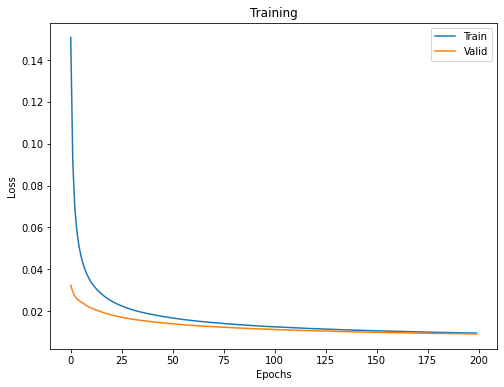

In [22]:
plot(deep_train_loss, deep_val_loss)

Final MSE: 0.00905274


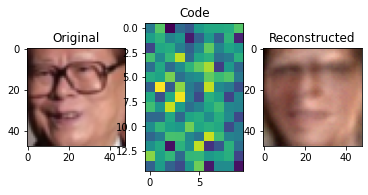

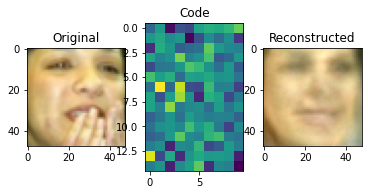

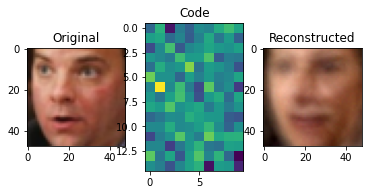

In [23]:
score = deep_val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img, deepmodel, div_coef=10)

4) Свёрточный автокодировщик (в качестве домашнего задания)
Добавим свёрточные слои и немного макспулинга. Часть, которая относится к энкодеру будет стандартной. Это просто свёрточные слои и пулинг. Кончается она обычным свёрточным слоем с code_size нейронов. В качестве функции активации берите elu.

Попробуйте повторить свёртку и пулинг  2×2  четыре раза с ядром размера  3×3 , padding выбирете таким образом, чтобы сохранилась пространственная размероность картинки. У слоёв поставьте число каналов:  32 ,  64 ,  128 ,  256 .

Для декодера мы будем использовать

torch.nn.Upsample с scale_factor равным 2 и torch.nn.ConvTranspose2d.

Проведите эксперименты с разными подходами Unpooling, сравните результаты, напишите ваши наблюдения!

Продолжение д/з:

Обучите модель и постройте график падения ошибки.
Выведите привычные картинки "до/после" автоэнкодера для нескольких объектов из test выборки (подсказка: с помощью ранее определенной функции visualize)

In [24]:
class CNNAutoencoder(nn.Module):

    def __init__(self, code_size=150):

        super().__init__()
        
        
        self.encoder = nn.Sequential(
                        
           nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(32),
           nn.ELU(),
           nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Conv2d(in_channels=32, out_channels=code_size, kernel_size=3, stride=1, padding=1),
       )
        self.decoder = nn.Sequential(
            
           nn.ConvTranspose2d(in_channels=code_size, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(32),
           nn.ELU(),
           nn.Upsample(scale_factor=2, mode='bilinear'),
           nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
        )
        
        # self.apply(initialization)
        
    def forward(self, x):
        #init_shape = x.shape
        #x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code


In [25]:
# Train your autoencoder
# Немного подредактировала код, чтобы чаще выводились результаты обучения

def train(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())

        model.eval()
        with torch.no_grad():
            for X in val_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch)

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 3 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

In [26]:
criterion = torch.nn.MSELoss()

CNNAutoencoder_ = CNNAutoencoder()
CNNAutoencoder_.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(CNNAutoencoder_.parameters(), lr=7e-4)

In [27]:
CNNmodel, deep_train_loss, deep_val_loss = train(CNNAutoencoder_, 
                                                  train_loader, test_loader, 
                                                  device=DEVICE, epochs=40, 
                                                  path='CNNAutoencoder')
torch.save(CNNmodel.state_dict(), 'CNNAutoencoder' + '/CNN_auto_model_final.pt')

  0%|          | 0/40 [00:00<?, ?it/s]

After 0 epochs, training loss: 1.521575;   val loss: 0.323790
After 3 epochs, training loss: 0.623015;   val loss: 0.221281
After 6 epochs, training loss: 0.389931;   val loss: 0.156306
After 9 epochs, training loss: 0.283112;   val loss: 0.119405
After 12 epochs, training loss: 0.222674;   val loss: 0.096420
After 15 epochs, training loss: 0.183960;   val loss: 0.081254
After 18 epochs, training loss: 0.157117;   val loss: 0.070479
After 21 epochs, training loss: 0.137283;   val loss: 0.062412
After 24 epochs, training loss: 0.122007;   val loss: 0.056094
After 27 epochs, training loss: 0.109900;   val loss: 0.051016
After 30 epochs, training loss: 0.100095;   val loss: 0.046861
After 33 epochs, training loss: 0.091939;   val loss: 0.043427
After 36 epochs, training loss: 0.085067;   val loss: 0.040470
After 39 epochs, training loss: 0.079182;   val loss: 0.037912


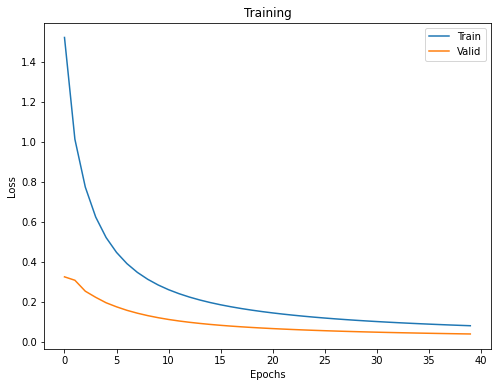

In [28]:
plot(deep_train_loss, deep_val_loss)

In [29]:
# Функция для отрисовки оригинальных цифр, их представления и восстановленного рисунка - немного переделана под CNNAutoencoder
def visualize(img, model, div_coef=2):
    with torch.no_grad():
        x = img #torch.flatten(img)
        x = x[None, :]
        latent_code = model.encoder(x.to(DEVICE))[0].cpu()

        reco, _ = model(img[None, :, :, :].to(DEVICE))
        reco = reco[0].cpu()
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(1,3,2)
    plt.title("Code")
    latent_code1 = latent_code.squeeze(0).detach().cpu().numpy()
    #latent_code2 = np.reshape(latent_code1, (18, 25, 3))
    latent_code2 = np.reshape(latent_code1, (160, 180, 3))
    latent_code2 = (latent_code2 * 255).astype(np.uint8)
    plt.imshow(latent_code2)

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1).permute(1, 2, 0))
    plt.show()

Final MSE: 0.037911884


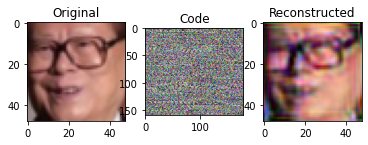

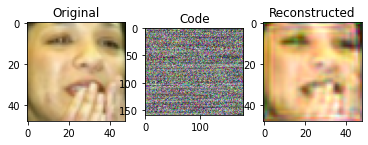

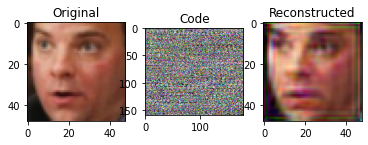

In [30]:
score = deep_val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img, CNNmodel, div_coef=10)

**Наблюдения:**
*   Сверточный автокодировщик долго учится
*   Результат реконструкции даже при 40 эпохах - лучше, чем у PCA и Deep при 200.
*   Сымый хороший результат получился при использовании (out_channels=32) 
*   MaxPool2d работает лучше, чем AvgPool2d


